In [4]:
%load_ext autoreload
import os
%autoreload 2
%aimport lasagne.datasets.infinite_image_dataset
%aimport lasagne.easy
#import theano.sandbox.cuda
#theano.sandbox.cuda.use("gpu1")


from lasagne import easy
import lasagne
import lasagne.data

# currently available datasets:
from lasagne.datasets import mnist, fonts, notmnist, insects, ilc, infinite_image_dataset


import theano.tensor as T
import theano
import os
import numpy as np
import time
import seaborn as sbn
import copy

from lasagne.layers.dense import DenseLayer
from lasagne.layers.base import Layer

from pylearn2.scripts.plot_weights import (grid_plot, 
                                           build_visualizations_by_weighted_combinations)

import matplotlib.pyplot as plt

from sklearn import cross_validation

%matplotlib inline

from theano.sandbox.rng_mrg import MRG_RandomStreams

# init a random number generator
rng =  MRG_RandomStreams(111222333)


Using gpu device 1: Tesla K20m


In [161]:
def build_model(x_dim, num_hidden_list, y_dim, nb_clusters, tied_weights=True):
    
    """
    This function builds a deep auto-encoder model reconstructing the input
    and in the same time predicting the labels.
    
    x_dim : dimensionality of the input
    y_dim : dimensionality of the output
    num_hidden_list : list of nb of hidden units of each layer         
    """
    l_x_in = lasagne.layers.InputLayer(
            shape=(None, x_dim),
        )
    l_y_in = lasagne.layers.InputLayer(
            shape=(None, y_dim),
        )

    
    
    # 1) First part of the auto-encoder : encoding part
    
    cur_layer = l_x_in
    weights = []
    for i, num_hidden in enumerate(num_hidden_list): # ?? num_hidden est 
                                            #le nbr de couches cachées? modifié : num_hidden_list est une liste
                                            # contenant le nombre d'unités dans 
                                            # chaque couche cachée 
        #lasagne.init.Uniform() use by default the Glorot et al initiliazition 
        # which works well for images (http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf)
        # alternatives : Normal(), Orthogonal(), Sparse(sparsity coef, standard dev of units)
        
        W = lasagne.init.Uniform()
        
        
        # Fill the biases with zero
        b = lasagne.init.Constant(0.)
        
        nonlinearity = lasagne.nonlinearities.sigmoid
            
        cur_layer = lasagne.layers.DenseLayer(
            cur_layer,
            num_units=num_hidden,
            nonlinearity=nonlinearity,
            W=W,
            b=b
        )
        weights.append(cur_layer.W)
    
    l_code = cur_layer # l_code is the topest layer of the encoder

    # 2) second part of the auto-encoder : the decoder
    num_hidden_list_backward = list(reversed(num_hidden_list))[1:]
    
    for i, num_hidden in enumerate(num_hidden_list_backward  + [x_dim] ):
        
        if tied_weights == True:            
            W = (weights[len(num_hidden_list) - i - 1].T)
        else:
            W = lasagne.init.Uniform()
        
        b = lasagne.init.Constant(0.)
        
        nonlinearity = lasagne.nonlinearities.sigmoid
     
        
        cur_layer = DenseLayer(
            cur_layer,
            num_units=num_hidden,
            nonlinearity=nonlinearity,
            W=W,
            b=b,
            tied_weights=tied_weights
        )
    
    
    # l_x_hat is the reconstruction layer : ^(x)
    l_x_hat = cur_layer
    
    # 3) a layer predicting the labels from the code
    
    
    # l_y_hat is the  layer of label predictions
    l_y_hat = lasagne.layers.DenseLayer( ## ?? C'est quoi denselayer?
                                        ## fully connected? Oui dense  = fully connected
        l_code,
        num_units = y_dim,
        nonlinearity=lasagne.nonlinearities.tanh
    )
    
    l_clusters_hat = lasagne.layers.DenseLayer( ## ?? C'est quoi denselayer?
                                        ## fully connected? Oui dense  = fully connected
        l_code,
        num_units = nb_clusters,
        nonlinearity=lasagne.nonlinearities.softmax
    )
    return l_x_in, l_y_in, l_code, l_x_hat, l_y_hat, l_clusters_hat


# the function that sets the loss function to minimize
def objective(X_batch, y_batch, x_hat, x_code, y_hat, clusters_hat, clustering_coeficient=0, prediction_coeficient=0):
    """
        X_batch : the given input
        y_batch : the given output
        x_hat : the reconstructed input
        y_hat : the predicted labels
        
    """  
    norms = T.sqrt(T.sum(x_code ** 2, axis=1))
    norms_classes = norms.reshape( (norms.shape[0], 1) ) * clusters_hat
    means_squares = T.sum(norms_classes**2, axis=0) / clusters_hat.sum(axis=0)
    square_means = (T.sum(norms_classes, axis=0) / clusters_hat.sum(axis=0)) ** 2
    variances = means_squares - square_means
    variances = T.sum(variances)    
    # minimize cross-entropy (for reconstruction)
    L = -( (X_batch * T.log(x_hat) + (1 - X_batch) * T.log(1 - x_hat)))
    reconstruction_loss = T.mean(  T.sum(L, axis=1)   )
    prediction_loss = T.mean(T.sum( (y_batch - y_hat)**2, axis=1 ))

    return reconstruction_loss + variances * clustering_coeficient + prediction_loss * prediction_coeficient

# Zero-Masking noise : corruption_level is the ratio by which we corrupt, 0.2 means
# 0.2 of the pixels will be randomly set to zero for each example
def corrupted_zero_masking(rng, x, corruption_level):
    return x * rng.binomial(size=x.shape, n=1, p=1 - corruption_level, dtype=theano.config.floatX)

# Salt And pepper noise : a subset of pixels are selected randomly and transformed fairly into 1 or 0
def corrupted_salt_and_pepper(rng, x, corruption_level):
    selected = rng.binomial(size=x.shape, n=1, p=corruption_level, dtype=theano.config.floatX)
    return x * (1 - selected) + selected * rng.binomial(size=x.shape, n=1, p=0.5, dtype=theano.config.floatX)


In [163]:
class Experiment(lasagne.easy.Experiment):
    """
    An experiment is an object doing all the steps we need:
    
      - 1) incorporating the dataset
      - 2) setting up the hyper-parameters
      - 3) building the model
      - 4) run it
      - 5) collect statistics and do some visualizations
    """

    def __init__(self, x_hidden_units):
        self.x_hidden_units = x_hidden_units
        self.rng = rng
        self.stats = []
    
    # - format the data so that labels are one-hot vectors instead of numbers
    # - set the train, valid and test set
    def load_data(self, datasets):
        self.train, self.valid, self.test =  datasets["train"], datasets["valid"], datasets["test"]
    
    # initialize the hyper-parameters
    def set_hp(self, hp=None):
        if hp is None:
            hp = {}
        self.learning_rate = hp.get("learning_rate", 0.1)
        self.momentum = hp.get("momentum", 0.)
# ?? what does the next to line do? - I dont get the syntax (don't understand )
# it gets the dimensionality of the input from the dataset matrix (shape[1] is the number of columns)
        self.input_dim = self.train.X.get_value().shape[1]
        self.output_dim  = self.train.y.get_value().shape[1]
        self.batch_size = hp.get("batch_size", 20)
        self.nb_batches = self.train.X.get_value().shape[0] // self.batch_size
        self.nb_epochs = hp.get("nb_epochs", 15)
        self.corruption = hp.get("corruption", 0.3)
        self.clustering_coeficient = hp.get("clustering_coeficient", 0.)
        self.prediction_coeficient = hp.get("prediction_coeficient", 0.)
        self.generate_each_epoch = hp.get("generate_each_epoch", False)
        self.nb_clusters = hp.get("nb_clusters", 3)
    
    def build_model(self):
        
        self.batch_index, self.X_batch, self.y_batch, self.batch_slice = easy.get_theano_batch_variables(self.batch_size, 
                                                                                                         y_softmax=False)
        

        # creates the model
        self.l_x_in, self.l_y_in, self.l_code, self.l_x_hat, self.l_y_hat, self.l_clusters_hat = build_model(self.input_dim, 
                                                                                        self.x_hidden_units,
                                                                                        self.output_dim,
                                                                                        self.nb_clusters)
        
        # get the corrupted version of the input
        self.corrupted_X_batch = corrupted_zero_masking(self.rng, self.X_batch, self.corruption)


        # get the loss function
        self.loss = objective(self.X_batch,
                              self.y_batch,
                              self.l_x_hat.get_output(self.corrupted_X_batch), # the reconstruction from the corrupted input,
                              self.l_code.get_output(self.corrupted_X_batch),
                              
                              self.l_y_hat.get_output({self.l_x_in : self.X_batch, 
                                                       self.l_y_in : self.y_batch} ),# the prediction label
                              self.l_clusters_hat.get_output({self.l_x_in : self.X_batch}),
                              clustering_coeficient=self.clustering_coeficient,
                              prediction_coeficient=self.prediction_coeficient)
        
    
        
        # the predictions
        pred = T.argmax(self.l_y_hat.get_output({self.l_x_in : self.X_batch, self.l_y_in : self.y_batch}),
                        axis=1)
        # the accuracy
        accuracy = T.mean(T.eq(pred, T.argmax(self.y_batch, axis=1)))
        #reconstruction_error =  T.mean( T.sum( T.abs_(self.l_x_hat.get_output(self.X_batch) - self.X_batch), axis=1 ) )
        z = self.l_x_hat.get_output(self.X_batch)
        x = self.X_batch
        L = - T.sum(x * T.log(z) + (1 - x) * T.log(1 - z), axis=1)
        reconstruction_error = T.mean(L)

        # a function that computes the loss
        self.get_loss = theano.function([self.X_batch, self.y_batch], self.loss)
        # a function that get the reconstructions
        self.get_reconstruction = theano.function([self.X_batch],
                                                   self.l_x_hat.get_output(self.X_batch))
        self.get_reconstruction_error = theano.function([self.X_batch],
                                                        reconstruction_error)
        
        self.get_clusters = theano.function([self.X_batch],
                                            self.l_clusters_hat.get_output({self.l_x_in : self.X_batch}))
        
        code = T.matrix('code')
        self.get_reconstruction_from_code = theano.function([code],
                                                             self.l_x_hat.get_output({self.l_code : code}) )
        
        # a function that gets the code
        self.get_code = theano.function([self.X_batch], self.l_code.get_output(self.X_batch))
        
        # a function that gets the accuracy                  
        self.get_accuracy = theano.function([self.X_batch, self.y_batch], accuracy)
        

        # get the gradient updates
        all_params = lasagne.layers.get_all_params(self.l_x_hat)
        
        # uses adadelta as on optimization procedure (http://www.matthewzeiler.com/pubs/googleTR2012/googleTR2012.pdf)
        #self.updates = lasagne.updates.adadelta(self.loss, all_params, learning_rate=self.learning_rate)
        self.updates = lasagne.updates.nesterov_momentum(self.loss, all_params, learning_rate=self.learning_rate,
                                                         momentum=self.momentum)

        # get the iteration update
        self.iter_update_batch = easy.get_iter_update_supervision(self.train.X, self.train.y, self.X_batch, self.y_batch,
                                                                  self.loss, self.updates,
                                                                  self.batch_index, self.batch_slice)
        
        
    def run(self):
        train, valid, test = self.train, self.valid, self.test

        def iter_update(epoch):
            """
            - this function is called in each epoch
            - it returns (in each epoch) an update status : it is a dict containing 
              the loss, accuracy, reconstruction error of train, valid and test sets
            """
            if self.generate_each_epoch == True:
                train.load()
                train.X = theano.shared(train.X)
                train.y = theano.shared(train.y)
    
            # for each batch, update the parameters
            for i in xrange(self.nb_batches):
                self.iter_update_batch(i)

            # get the loss of train, valid  and test sets
            ds = {"train": train, "valid": valid, "test": test}
            status = {}
            for k, v in ds.items():
                X, y = v.X.get_value(), v.y.get_value()
                status["loss_" + k] = self.get_loss(X, y)
                status["accuracy_" + k] = self.get_accuracy(X, y)
                status["reconstruction_error_" + k] = self.get_reconstruction_error(X)
                
            status["epoch"] = epoch
            return status

        def quitter(update_status):
            """
                in each epoch quitter is called to check if the program will stop before reaching the
                given number of epochs
            """
            
            # here we don't stop
            return False

        def monitor(update_status):
            """
                in each epoch, get the update_status from iter_update.
                returns the monitor output which will be communicated to the observer.
            """
            self.stats.append(update_status)
            return update_status
        
        
        def observer(monitor_output):
            """
                get the status of the current epoch from the monitor and shows it
            """
            if monitor_output["epoch"] % 20 == 0:
                for k, v in monitor_output.items():
                    print("%s : %f" % (k, v))
        
        
        # train the model
        lasagne.easy.main_loop(self.nb_epochs, iter_update, quitter, monitor, observer)
    
    # after training the model, show the reconstructions
    def post_show_reconstructions(self, nb=30):
        x = easy.get_2d_square_image_view(self.train.X.get_value())
        x_rec = self.get_reconstruction(self.train.X.get_value())
        x_rec = easy.get_2d_square_image_view(x_rec)
        
        indices = np.random.randint(0, x.shape[0] - 1, size=(nb,))

        k = 1
        for i in xrange(nb):
            plt.subplot(nb, 2, k)
            plt.axis('off')
            plt.imshow(x[indices[i]], cmap='gray')
            k += 1
            plt.subplot(nb, 2, k)
            plt.axis('off')
            plt.imshow(x_rec[indices[i]], cmap='gray')
            k += 1
        plt.show()

In [164]:
layerwise_autoencoders_hidden = [  [256, 100]  ]

# Load  dataset
dataset = lasagne.datasets.mnist.MNIST() # change by lasagne.datasets.datasets.mnist.MNIST
                                         # or by lasagne.datasets.fonts.Fonts with (kind='all_32', labels_kind='letters')
                                         # or by lasagne.datasets.notmnist.NotMNIST
                                         # or by lasagne.datasets.insects.Insects 
                                         # or by lasagne.datasets.ilc.ILC
dataset.load()
dataset.y = lasagne.utils.floatX(lasagne.easy.to_hamming(dataset.y, presence=1, absence=-1))


data_is_generated = False # make it True if you want to use InfiniteImageDataset
    
#mean = dataset.X.mean(axis=0)[np.newaxis, :]
#std = dataset.X.std(axis=0)[np.newaxis, :] 
# standardize
#dataset.X = (dataset.X - mean) / (std + (std==0))
# Split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dataset.X, dataset.y, test_size=0.25)
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X_train, y_train, test_size=0.25)




X_train = theano.shared(X_train, borrow=True)
X_valid = theano.shared(X_valid, borrow=True)
X_test = theano.shared(X_test, borrow=True)
y_train = theano.shared(y_train, borrow=True)
y_valid = theano.shared(y_valid, borrow=True)
y_test = theano.shared(y_test, borrow=True)


datasets = {"train" : lasagne.data.Dataset(X_train, y_train), 
            "valid": lasagne.data.Dataset(X_valid, y_valid),
            "test": lasagne.data.Dataset(X_test, y_test)}

params = {}


# InfiniteImageDataset
if data_is_generated:
    X_initial = dataset.X[2:3]
    y_initial = dataset.y[2:3]
    nb_examples = {
        "train": 500,
        "valid": 100,
        "test": 100
    }
    params = {
        "x_translate_max":1, 
        "y_translate_max":1, 
        "theta_range":(-np.pi / 5, np.pi / 5),
        "rgb": False
    }
    for name, ds in datasets.items():
        X, y = ds.X.get_value(), ds.y.get_value()
        ds = datasets[name] = infinite_image_dataset.InfiniteImageDataset(X_initial, y_initial, nb_examples[name], params)
        ds.load()
        ds.X = theano.shared(ds.X, borrow=True)
        ds.y = theano.shared(ds.y, borrow=True)

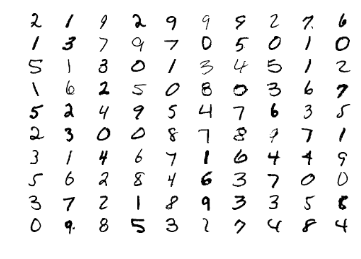

In [78]:
# Visualize the dataset
grid_plot(lasagne.easy.get_2d_square_image_view(datasets['train'].X.get_value()), nbrows=10, nbcols=10, random=True)

In [165]:
# un experiment c'est un entrainment d'un auto-encoder.
# dans chaque experiment on entraine un auto-encoder pour reconstruire la couche precedente (greedy layer-wise auto-encoders)
# apres chaque expriment on transforme le dataset en utilisant l'auto-encoder qu'on a entrainé
# On garde les data générés pour chaque couche

# ?? que veut dire: reconstruction_error_wrong_pixels_per_example_train, rennomée en reconstruction_error
# je voulais juste dire que c'est le nombre de pixels erronés en moyenne pour chaque exemple

# initialize the experiments
reconstruct_previous_layer_experiments = []
for nb_hidden in layerwise_autoencoders_hidden:
    if type(nb_hidden) != list:
        nb_hidden = [nb_hidden]
    exp = Experiment(nb_hidden)
    reconstruct_previous_layer_experiments.append(exp)

cur_datasets = datasets
for i, exp in enumerate(reconstruct_previous_layer_experiments):
    print "Training the layer %d" % (i,)
    # Reconstruct the previous layer (for the first experiment, reconstruct the input)
    exp.load_data(cur_datasets)
    hp = {
        "nb_epochs": 200,
        "corruption": 0.,
        "batch_size": 128,
        "learning_rate": 0.05,
        "momentum": 0.8,
        "nb_clusters": 10,
        # predict the labels only for the last layer
        "prediction_coeficient" :  (0. if i == len(reconstruct_previous_layer_experiments)-1 else 0.),
        "clustering_coeficient" : 0.5,
        # Used to generate dataset in each epoch (InfiniteImageDataset)
        "generate_each_epoch" : True if (i == 0 and data_is_generated) else False
    }
    exp.set_hp(hp)
    exp.build_model()
    exp.run()
    # transform the datasets splits using the new learned auto-encoder
    new_datasets = {}
    for name, dataset in cur_datasets.items():
        X, y = dataset.X, dataset.y
        X = theano.shared(exp.get_code(X.get_value()))
        new_datasets[name] = lasagne.data.Dataset(X, y)
    cur_datasets = new_datasets

Training the layer 0
accuracy_train : 0.111213
loss_test : 24.659607
reconstruction_error_test : 474.774506
loss_valid : 25.505157
loss_train : 25.101654
epoch : 0.000000
accuracy_valid : 0.113905
accuracy_test : 0.114457
reconstruction_error_train : 475.192871
reconstruction_error_valid : 475.601196
accuracy_train : 0.111213
loss_test : -83.331726
reconstruction_error_test : 366.789001
loss_valid : -82.771179
loss_train : -83.074615
epoch : 20.000000
accuracy_valid : 0.113905
accuracy_test : 0.114457
reconstruction_error_train : 367.023895
reconstruction_error_valid : 367.329620
accuracy_train : 0.111213
loss_test : -115.688416
reconstruction_error_test : 334.431427
loss_valid : -115.263885
loss_train : -115.419525
epoch : 40.000000
accuracy_valid : 0.113905
accuracy_test : 0.114457
reconstruction_error_train : 334.672638
reconstruction_error_valid : 334.835480
accuracy_train : 0.111213
loss_test : -144.905518
reconstruction_error_test : 305.211853
loss_valid : -144.111359
loss_train 

In [117]:
# Build the stats for plots

splits = ("train", "valid", "test")

def get_stats(experiment, stat_names):
    stats = {}
    for spl in splits:
        stats[spl] = {}
        for v in stat_names:
            stats[spl][v] = [stat[v + "_" + spl] for stat in experiment.stats]
    return stats

def plot_stat(stats, stat_name):
    for spl in splits:
        plt.plot(stats[spl][stat_name], label="%s %s" % (spl, stat_name))
    plt.legend(bbox_to_anchor=(0.5, 1.05))
    plt.xlabel("epoch")



    
stat_names = ["accuracy", "loss", "reconstruction_error"]
stats = get_stats(reconstruct_previous_layer_experiments[0], stat_names)



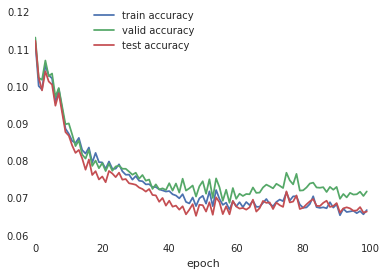

In [118]:
plot_stat(stats, "accuracy")
plt.show()

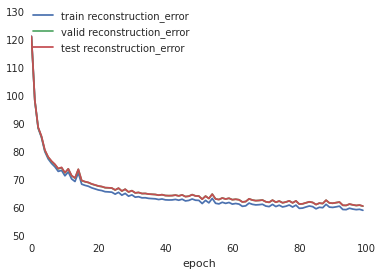

In [119]:
plot_stat(stats, "reconstruction_error")
plt.show()

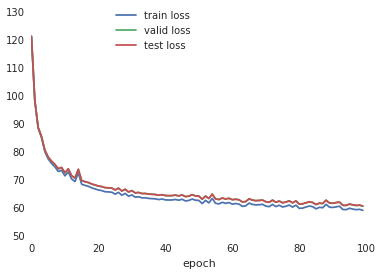

In [120]:
plot_stat(stats, "loss")
plt.show()

In [121]:
#get the weights of each layer
weights = []
for exp in reconstruct_previous_layer_experiments:
    all_params = lasagne.layers.get_all_params(exp.l_x_hat)
    W = all_params[1].get_value().T # get te weight matrix
    weights.append(W)

#build the visualizations of each layer
vis = build_visualizations_by_weighted_combinations(weights, until_layer=len(reconstruct_previous_layer_experiments)-1, top=0.01)


IndexError: tuple index out of range

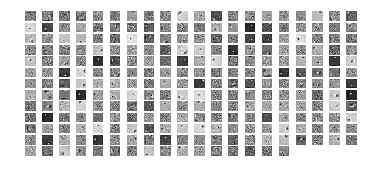

In [122]:
# une qui genere le visualisations recursivement : le visualisation d'une unité A du layer N
# est la moyenne des visualizations de X unités du layer N - 1 avec lesquelles
#  l'unité A a la plus grosse connectivité (en termes de poids reliant A aux couches du layer precedent)
# La deuxieme méthode prend la moyenne des top X examples qui maximisent l'activation de l'unité

# ?? Peut-on échantillonner et afficher les échantillons? Faut éventuellement les faire.

# Visualize the first layer
grid_plot(vis[0], imshow_options={"cmap": "gray"}, nbrows=20, nbcols=20, random=False)
plt.show()

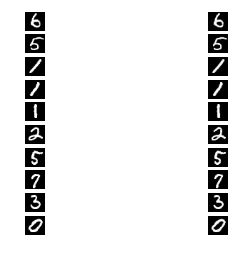

In [31]:
# show reconstructions
reconstruct_previous_layer_experiments[0].post_show_reconstructions(nb=10)

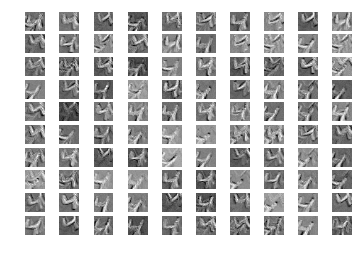

In [16]:
# visualize the second layer (if available)
grid_plot(vis[1], imshow_options={"cmap": "gray"}, nbrows=10, nbcols=10, random=True)
plt.show()

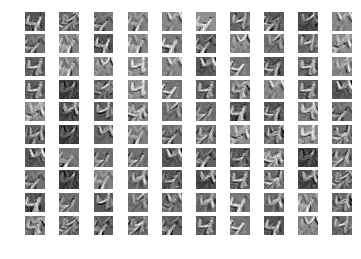

In [16]:
# visualize the third layer (if available)
grid_plot(vis[2], imshow_options={"cmap": "gray"}, nbrows=10, nbcols=10, random=True)
plt.show()

In [166]:
# Compute the representations of each layer for 'test' dataset
dataset = datasets['test']
X = dataset.X.get_value()
representations = [X]
for exp in reconstruct_previous_layer_experiments:
    X = exp.get_code(X)
    representations.append(X)

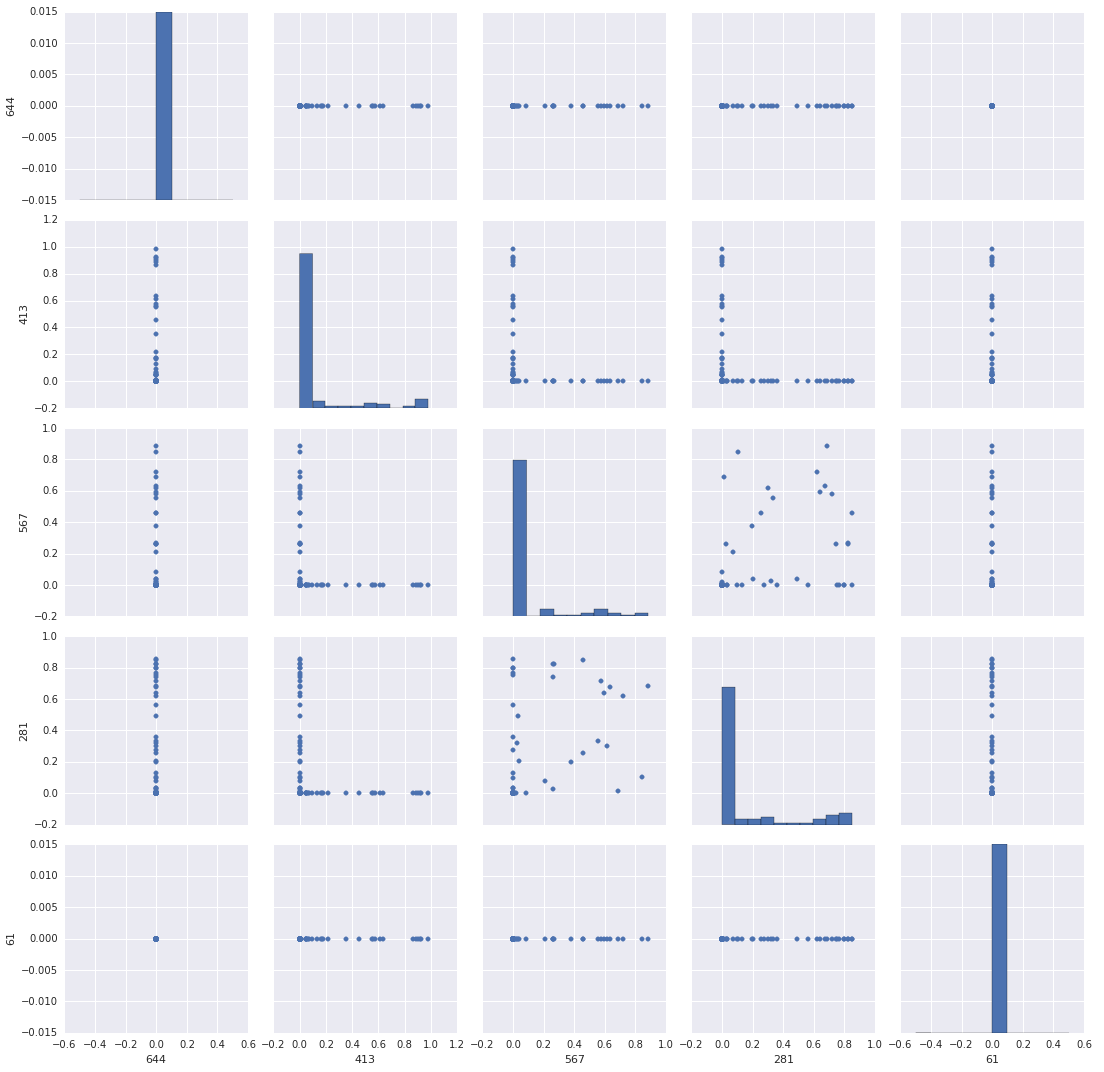

In [21]:
import pandas as pd

# Plot the distributions of the representation of a given layer
# Randomly selection of a set of features in the representation and
# plot in a grid the following:
# - For non-diagonal locations, plot relationship between two features
# - For diagonal ones, plot the histogram of a feature
# The id of the selected features is in "selected_features"

# If we want "easy" sampling with auto-encoders, we need the last layer to be uniform...

layer = 0
representation = representations[layer]

selected_features = np.random.randint(0, representation.shape[1] - 1, size=5)

reprenstation = pd.DataFrame(representation)
g = sbn.PairGrid(reprenstation, vars=selected_features)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [19]:
# or we can model the last layer representation using an RBM (a simple one if possible)...

from sklearn.neural_network.rbm import BernoulliRBM
representation = representations[-1]
print reprenstation.shape
model = BernoulliRBM(n_components=80, n_iter=100)
model.fit(representation)

def sample_from_rbm(rbm, nb_examples, nb_iterations=10):
    nb_features = rbm.components_.shape[1]
    v = np.random.uniform(size=(nb_examples, nb_features))
    for i in xrange(nb_iterations):
        v = rbm.gibbs(v)
    return v

(100, 784)


In [34]:
# The sampling  part


nb_examples = 50 # nb of examples to sample
nb_iterations = 150 # nb of gibbs iterations

# sample from RBM
X = sample_from_rbm(model, nb_examples, nb_iterations)

# go back to the input layer
for exp in reversed(reconstruct_previous_layer_experiments):
    X  = exp.get_reconstruction_from_code(X)


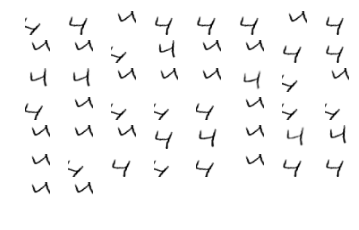

In [21]:
# Show the samples
grid_plot(lasagne.easy.get_2d_square_image_view(X))

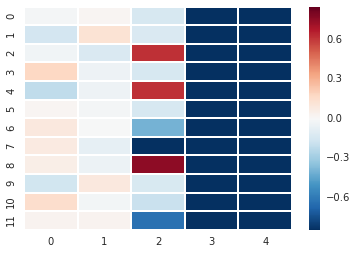

In [22]:
# Correlation matrix between a layer of representation and params that generate the data (translation, scale, rotation) in case InfiniteMnistDataset is used

layer_to_study = 4
corr = np.corrcoef(representations[layer_to_study].T, datasets['test'].X_params.T)
corr = corr[0:representations[i].shape[1], representations[i].shape[1]:]
sbn.heatmap(corr)
plt.show()

# On rows : features of the representation layer
# On cols : features of the params that generate the data
# ---> Discard  cols 3 and 4, they represent scale of x and y, the value of these features 
#      is always constant because we don't change the scale of the images

100


/home/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/matplotlib/animation.py:727: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


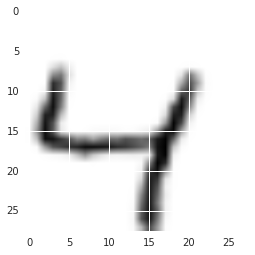

In [23]:
#Show the effect of changing a feature on a layer (typically the topest layer) with respect to the input layer
import matplotlib.animation as animation
# Use the last layer as starting point
repr_start = len(representations) - 1
# browse different values for this feature in the layer
browse_feature = 2

X = representations[repr_start]

min_feat = min(X[:, browse_feature])
max_feat = max(X[:, browse_feature])
fig  = plt.figure()
nb_bins = 100
ims = []
for i in xrange(nb_bins):
    
    X = representations[repr_start].copy()
    value_for_feat = min_feat + (max_feat - min_feat) * float(i)/nb_bins
    X[:, browse_feature] = value_for_feat
    # get back to the input
    for exp in reversed(reconstruct_previous_layer_experiments[0:repr_start]):
        X  = exp.get_reconstruction_from_code(X)
    
    #grid_plot(easy.get_2d_square_image_view(X))
    X_im = easy.get_2d_square_image_view(X)
    ims.append([plt.imshow(X_im[30])])


print len(ims)
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)
ani.save("video.gif")
plt.show()

In [24]:
from IPython.display import Image
Image(url='video.gif')

In [167]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
nb = 200
dataset = datasets['test']
X = dataset.X.get_value()[0:nb]
y = np.argmax(dataset.y.get_value()[0:nb], axis=1)
clusters = reconstruct_previous_layer_experiments[-1].get_clusters(X)
code = representations[-1][0:nb]
mds = MDS(n_components=2)
code_2d = mds.fit_transform(code)
clusters_ = np.argmax(clusters, axis=1) + 1

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
1.0


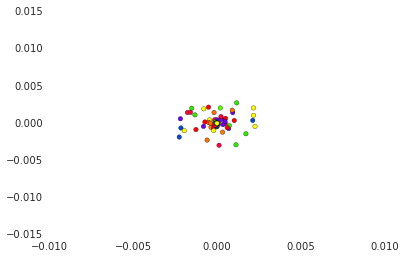

In [168]:
print clusters_
print  code.max()
import matplotlib
plt.scatter(code_2d[: , 0], code_2d[:, 1],  c=y, cmap=matplotlib.cm.prism)
plt.show()

In [ ]:
from collections import defaultdict
assoc = defaultdict(int)
mat = np.zeros ( (  max(clusters_), len(set(y))) )
for a in clusters_:
    for b in y:
        mat[a - 1, b] += 1

print mat